# LLM detection
## Assignment #3
###  Practical Data Science course, MSc in Data Science (2023/2024)

---

> Dimitris Tsirmpas <br>
> MSc in Data Science f3352315 <br>
> Athens University of Economics and Business

## Data Augmentation

We begin by reviewing the data provided to us by the competition:

In [1]:
import pandas as pd
import numpy as np
import os


DATA_PATH = os.path.join("..", "data")

In [2]:
train_df = pd.read_csv(os.path.join(DATA_PATH, "train_essays.csv"))
train_df

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


Out of these we have been provided with only 3 generated essays:

In [3]:
train_df[train_df.generated == 1]

,id,prompt_id,text,generated
704,82131f68,1,"This essay will analyze, discuss and prove one...",1
740,86fe4f18,1,I strongly believe that the Electoral College ...,1
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1


### Prompting

Unless we procure more data the task is impossible. We will thus use prompting to produce our own generated dataset.

For this task we will use ChatGPT. The prompts were manually given using the official website, and exported the responses in MarkDown form using the very convinient [ChatGPT Conv Down](https://addons.mozilla.org/en-US/firefox/addon/chatgpt-convdown/) Firefox addon. 

We used three prompting strategies to procure our generated dataset:
* The standard prompt (used for the human essays) without sources
* The standard prompt using all the sources, with a role prompt to persuade the model into writing in a more simplistic tone mirroring the tone used in the human essays
* The standard prompt with a role prompt, using a different subset of the sources each time 
* The standard prompt with a role prompt and a different subset of the human essays instead of sources, in order to "mimick" the tone and style of these essays

This procedure was repeated for both types of prompts provided in the dataset (car-free cities and the Electoral College). The conversation context was periodically refreshed in order to avoid the model repeating its own generated essays. Following this procedure we hope to obtain a thorough dataset being as close as possible to the actual operational dataset.

Details on the prompts themselves can be found in `report.pdf`.

### Dataset Caveats

Unfortunately, even following the above strategy does not yield as good results as we would hope for. The biggest isse by far is that ChatGPT's output is formulaic and carries a distinct tone which is most of the time distinct from the students'. 

Role prompting and including human essays as input slightly alleviates the problem but does not eradicate it. Trying to explictly set the tone of the generated essays leads to a complete collapse in tone, with outputs as *artistic* as the one below:

>Dear [Senator's Name],
>
>Hope this letter finds you chill. I wanted to throw my two cents into the mix about the whole Electoral College debate. It's like a hot topic, right? Some say we should keep it, others are all about switching to the popular vote. Here's where I'm at.
>
>So, keeping the Electoral College – it's got its quirks, but it's not all bad. I get it, voting for electors instead of the actual president seems a bit weird. But, like, it's been working, hasn't it? It's like a system our folks set up ages ago, and yeah, maybe it's not perfect, but it's got a rhythm." [...]


### Importing the generated dataset

In [4]:
def read_gpt(file: str) -> pd.Series:
    """
    Read and extract ChatGPT responses from a file.

    :param file: A string specifying the name of the file to be read.
    :type file: str

    :return: A pandas Series containing ChatGPT responses extracted from the file.
    :rtype: pd.Series
    """
    with open(os.path.join(DATA_PATH, file), encoding="utf8") as f:
        contents = f.read()
    responses = list(filter(lambda x: x.startswith(" ChatGPT"), 
                        contents.split("##")))
    clear_responses = [res.replace("ChatGPT", "").replace("~", "").strip() 
                            for res in responses]
    return pd.Series(clear_responses)


chat_gpt_environment = read_gpt("chatgpt_cars.md")
envir_df = pd.DataFrame({"id": [str(id(text)) for text in chat_gpt_environment],
                         "text": chat_gpt_environment, 
                         "prompt_id": np.zeros_like(chat_gpt_environment),
                         "generated": np.ones_like(chat_gpt_environment)})

chat_gpt_electoral = read_gpt("chatgpt_electoral.md")
elect_df = pd.DataFrame({"id": [str(id(text)) for text in chat_gpt_electoral],
                         "text": chat_gpt_electoral, 
                         "prompt_id": np.ones_like(chat_gpt_electoral),
                         "generated": np.ones_like(chat_gpt_electoral)})

We will export the entire dataset, but will only use a subset of it in training. This is because of the low quality data encountered in the first prompts, where the generated texts do not match the tone or the contents of the human essays.

In [5]:
import os


OUTPUT_DIR = "..\output"

def csv_output(df: pd.DataFrame, filename: str) -> None:
    """
    Save a pandas DataFrame to a CSV file.

    :param df: The DataFrame to be saved.
    :type df: pd.DataFrame

    :param filename: The name of the CSV file.
    :type filename: str

    :return: This function does not return anything.
    :rtype: None
    """
    file = os.path.join(OUTPUT_DIR, filename)
    df.to_csv(file, encoding = 'utf8')
    print(f"File saved successfully as {file}")


augmentation_df = pd.concat([envir_df, elect_df])
csv_output(augmentation_df, "augmentation.csv")

File saved successfully as ..\output\augmentation.csv


In [6]:
# discard most low-quality datapoints
df = pd.concat([envir_df[90:], elect_df[90:], train_df])
df

,id,text,prompt_id,generated
90,2172896571728,In the face of escalating environmental concer...,0,1
91,2172895066400,In the wake of growing environmental concerns ...,0,1
92,2172896577904,In the face of pressing environmental concerns...,0,1
93,2172895069456,"In our quest for a sustainable future, limitin...",0,1
94,2172897025792,"In an era marked by environmental concerns, he...",0,1
...,...,...,...,...
1373,fe6ff9a5,There has been a fuss about the Elector Colleg...,1,0
1374,ff669174,Limiting car usage has many advantages. Such a...,0,0
1375,ffa247e0,There's a new trend that has been developing f...,0,0
1376,ffc237e9,As we all know cars are a big part of our soci...,0,0


### Preprocessing

We execute the following preprocessing steps:
* Remove all placeholder tags such as [Your Name], and which are exclusively used by ChatGPT
* Turn all text to lowercase
* Remove stopwords

In [7]:
# sample text
df.text.loc[df.text.apply(lambda x: x.startswith("Dear"))].iloc[3]

'Dear [State Senator\'s Name],\n\nI hope this letter finds you in good health and high spirits. As a high school student invested in understanding the intricacies of our political system, I wanted to share my perspective on the ongoing debate regarding the Electoral College and its role in electing the President of the United States.\n\nThere has been a lot of talk about whether we should keep or abolish the Electoral College. After careful consideration of various viewpoints, I find myself leaning towards the idea of keeping the Electoral College intact. While I acknowledge the concerns raised by those advocating for a shift to a popular vote system, I believe the Electoral College serves a crucial role in maintaining the fairness and efficacy of our electoral process.\n\nOne compelling argument in favor of the Electoral College is that it provides a clear and decisive outcome in presidential elections. The "winnertakeall" system, as mentioned in Example 1, ensures that a candidate wh

In [8]:
import re


bracket_regex = r"\[.*?\]"

df.text = df.text.apply(lambda x: re.sub(bracket_regex, "", x))
df.text = df.text.apply(lambda x: x.lower())

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections.abc import Iterable


# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
def remove_stopwords(words: str, stopwords: Iterable[str]) -> str:
    word_tokens = word_tokenize(words)
    # converts the words in word_tokens to lower case and then checks whether 
    #they are present in stop_words or not
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    #with no lower case conversion
    filtered_sentence = []
     
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    return " ".join(filtered_sentence)


stop_words = set(stopwords.words('english'))
df.text = df.text.apply(lambda x: remove_stopwords(x, stop_words))

The resulting text resembles the following:

In [10]:
df.text.loc[df.text.apply(lambda x: x.startswith("dear"))].iloc[3]

"dear , hope letter finds good health high spirits . high school student invested understanding intricacies political system , wanted share perspective ongoing debate regarding electoral college role electing president united states . lot talk whether keep abolish electoral college . careful consideration various viewpoints , find leaning towards idea keeping electoral college intact . acknowledge concerns raised advocating shift popular vote system , believe electoral college serves crucial role maintaining fairness efficacy electoral process . one compelling argument favor electoral college provides clear decisive outcome presidential elections . `` winnertakeall '' system , mentioned example 1 , ensures candidate secures majority state receives electoral votes . minimizes chances ties expedites decision-making process , providing swift clear winner . system , though without flaws , historically delivered results aligned popular vote . additionally , electoral college encourages cand

In [11]:
print(f"Number of generated essays in the dataset: {(df.generated == 1).sum()}")

Number of generated essays in the dataset: 132


In [12]:
# check for null values
df.isnull().values.any()

False

We also may need to convert the dataframe's types.

In [13]:
df.dtypes

id           object
text         object
prompt_id    object
generated    object
dtype: object

In [14]:
df.prompt_id = df.prompt_id.astype(int)
df.generated = df.generated.astype(int)
df.dtypes

id           object
text         object
prompt_id     int32
generated     int32
dtype: object

### More augmentation?

Another idea would be to use other standard NLP augmentation techniques such as randomly deleting/inserting words, purposefully inserting typographical mistakes in the text or even [replacing words with close synonyms](https://www.kaggle.com/code/rohitsingh9990/data-augmentation-by-synonym-replacement). However, all of these strategies would ultimately hurt the quality of our dataset, since typos and specific words are very valuable tools in LLM detection.

## Classifiers

In [15]:
from sklearn.model_selection import train_test_split


data_train, data_test = train_test_split(df,
                                         train_size=0.7, 
                                         test_size=0.3, 
                                         stratify=df.generated,
                                         random_state=42)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer().fit(data_train.text)
x_train = vectorizer.transform(data_train.text)
y_train = data_train.generated.values
x_test = vectorizer.transform(data_test.text)
y_test = data_test.generated.values

The metric we will be using is Macro-F1 average.

- **F1** is a metric used to balance the need for making sure our classifications for a category are both correct (precision) and represent as many of the actual cases of the category as possible (recall).
- **Macro-F1** is the unweighted average of all F1 metrics for each class. We choose Macro F1 instead of a weighted average because we have an unbalanced dataset (Generated essays data are a small fraction of overall essays)


Thus, we want to use a metric which favors both thorough and precise classifiers, and which also assigns equal importance to our smaller classes.

In [17]:
from sklearn.model_selection import cross_val_score


def cross_val_res(model, x, y, scoring=None, cv=10):
    """
    Minor utility method, wraping cross_val_score.
    """
    if scoring is None:
        scoring = "f1_macro"
    res = cross_val_score(model, x, y, cv=cv, scoring=scoring)
    return res.mean(), res.std()

### Dummy Classifier

We will first run a "fake" classifier which only guesses the majority category.

This dummy model thus completely disregards the input features and serves as a useful baseline with which to compare the subsequent classifiers.

In [18]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier


majority_model = DummyClassifier(strategy="most_frequent")
res = cross_val_res(majority_model, x_train, y_train)
print(f"Dummy Classifier mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Dummy Classifier mean macro F1-score 0.4772, std: 0.0010


### Naive Bayes

Naive Bayes is a very cheap and easy-to-interpret classifier, which checks for the probability that each individual word in the text will belong in any language. We generally want to use the simplest model for the job, and so we start with this reliable model which has proven itself in many fields in the past.

The `sklearn` library gives us access to many variations of Naive Bayes, each specialized in its own field. For this NLP task, we will be using `MultinomialNB`, which was suggested by [this blogpost](https://towardsdatascience.com/naive-bayes-classifiers-for-text-classification-be0d133d35ba).

In [19]:
from sklearn.naive_bayes import MultinomialNB


# naive bayes needs dense arrays to work 
naive_x_train = x_train.toarray()
naive_x_test = x_test.toarray()

naive_model = MultinomialNB()
res = cross_val_res(naive_model, naive_x_train, y_train)
print(f"Naive Bayes mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Naive Bayes mean macro F1-score 0.8168, std: 0.1139


In [20]:
naive_model = MultinomialNB().fit(x_train, y_train)
naive_res = naive_model.predict(x_test)
print(classification_report(y_test, naive_res, zero_division=0))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       413
           1       1.00      0.50      0.67        40

    accuracy                           0.96       453
   macro avg       0.98      0.75      0.82       453
weighted avg       0.96      0.96      0.95       453



### Logistic Regression

LogisticRegression despite its name is a linear classifier, meaning that it attempts to linearly separate the data into distinct categories. This interpretation does not apply well to a NLP task, but means that the classifier retains some very useful properties:

- The solution we get is a global optimum, meaning that it's the best we can get with the provided data. This means no hyper-parameter tuning is necessary and we can use the classifier as-is.
- It's a simple and very easy to compute classifier, since it solves a (mathematically simple) linear problem, albeit with some restrictions (technically those restrictions force it to use gradient descent, but the calculations are much easier than say, a neural network)

In [21]:
from sklearn.linear_model import LogisticRegression
import warnings


with warnings.catch_warnings():
    # ignore warnings about deprecated methods in libraries
    warnings.simplefilter("ignore")

    lr = LogisticRegression(max_iter=1000)
    res = cross_val_res(lr, x_train, y_train)
    print(f"Logistic Regression mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Logistic Regression mean macro F1-score 0.9239, std: 0.0528


In [22]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr = LogisticRegression(max_iter=1000).fit(x_train, y_train)
    lr_res = lr.predict(x_test)

print(classification_report(y_test, lr_res, zero_division=0))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       413
           1       1.00      0.68      0.81        40

    accuracy                           0.97       453
   macro avg       0.98      0.84      0.90       453
weighted avg       0.97      0.97      0.97       453



### Random Forest

Random Forest is an ensemble algorithm, which means it uses many simpler algorithms which then "vote" on a final decision. It has proven to be a good classifier on complex tasks, it combats overfitting by design (essentially by utilizing random chance in its training phase) and is still fairly easy to interpret.

The drawback is first and foremost computational, since we need to train many smaller classifiers, which may by themselves be computationally expensive (this is somewhat offset by the fact that the classifiers are indepednent and can be computed in parallel). Additionally, Random Forest is a non-parametric method which means that it is generally memory-intensive and may be slow to run on operational data. Finally, we also need to tune hyperparameters.

In [23]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=50,
                                      criterion="entropy")
res = cross_val_res(forest_model, x_train, y_train, cv=5)
print(f"Random Forest mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

Random Forest mean macro F1: 0.9608, std: 0.0266


In [24]:
forest_model = RandomForestClassifier(n_estimators=50, 
                                      criterion="entropy").fit(x_train, y_train)
forest_pred = forest_model.predict(x_test)
print(classification_report(y_test, forest_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       413
           1       1.00      0.88      0.93        40

    accuracy                           0.99       453
   macro avg       0.99      0.94      0.96       453
weighted avg       0.99      0.99      0.99       453



### Adaboost

Adaboost is the logical conclusion of Random Forests, where each voter considers a very specific "rule" that needs to be followed. The next voter then considers the most important rule to distinguish between the categories for all the clases that the first could not reliably classify, and so on.

This classifier is generally more compact and competent than a simple Random Forest, but is more computationally expensive during training because we cannot train it in parallel.

In [25]:
from sklearn.ensemble import AdaBoostClassifier


ada_model = AdaBoostClassifier(n_estimators=25)
res = cross_val_res(ada_model, x_train, y_train, cv=3)
print(f"AdaBoost mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

AdaBoost mean macro F1: 0.9685, std: 0.0094


In [26]:
ada_model = AdaBoostClassifier(n_estimators=25).fit(x_train, y_train)
ada_pred = ada_model.predict(x_test)
print(classification_report(y_test, ada_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       413
           1       0.97      0.90      0.94        40

    accuracy                           0.99       453
   macro avg       0.98      0.95      0.96       453
weighted avg       0.99      0.99      0.99       453



In [27]:
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer


best_model = ada_model
best_pred = best_model.predict(x_test)
c = make_pipeline(vectorizer, best_model)
explainer = LimeTextExplainer(class_names=best_model.classes_)

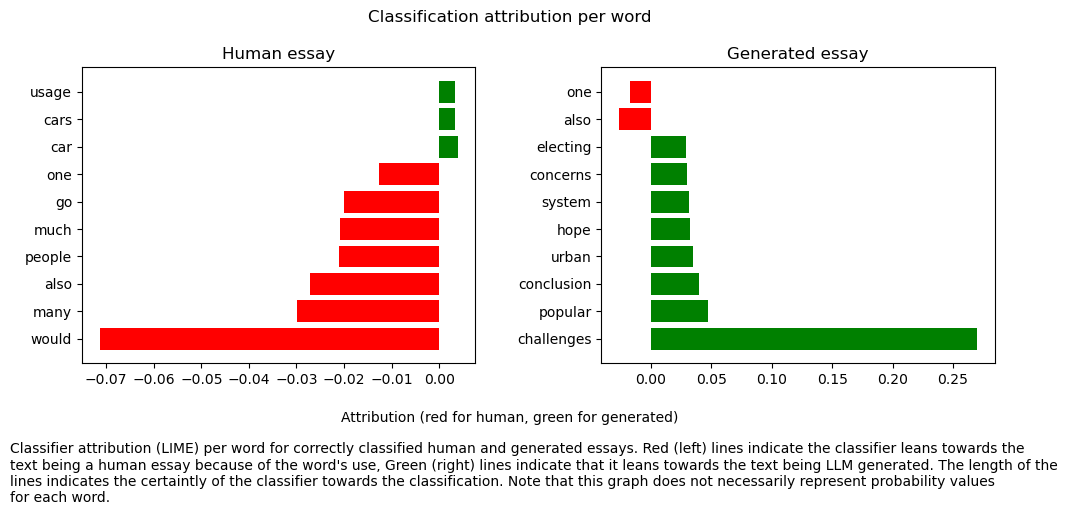

In [28]:
import matplotlib.pyplot as plt
import textwrap


# code for lime text and graph attributed to Ioannis Pavlopoulos
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)

# explanation for (correct) human classification
example_human = data_test[(data_test.generated == 0) & (best_pred == 0)].sample(1)
exp_human = explainer.explain_instance(example_human.text.iloc[0] , c.predict_proba)
exp_human_reversed = [(name, -value) for name, value in exp_human.as_list()]
word_scores_human = pd.DataFrame(exp_human.as_list(), columns=["word", "xscore"]) 
word_scores_human['color'] = word_scores_human.xscore.apply(lambda x: 'g' if x>0 else 'r')

axes[0].barh(word_scores_human.word, word_scores_human.xscore, color=word_scores_human.color)
axes[0].set_title("Human essay")

# explanation for generated classification
example = data_test[(data_test.generated == 1) & (best_pred == 1)].sample(1)
exp = explainer.explain_instance(example.text.iloc[0] , c.predict_proba)
word_scores = pd.DataFrame(exp.as_list(), columns=["word", "xscore"])
word_scores['color'] = word_scores.xscore.apply(lambda x: 'g' if x>0 else 'r')

axes[1].barh(word_scores.word, word_scores.xscore, color=word_scores.color)
axes[1].set_title("Generated essay")

caption_text = "Classifier attribution (LIME) per word for correctly classified human and generated essays. "\
                "Red (left) lines indicate the classifier leans towards the text being a human essay "\
                "because of the word's use, Green (right) lines indicate that it leans towards the text being LLM generated. "\
                "The length of the lines indicates the certaintly of the classifier towards the classification. "\
                "Note that this graph does not necessarily represent probability values for each word."

caption = textwrap.fill(caption_text, width=150)
fig.text(0, -0.25, caption)

fig.suptitle("Classification attribution per word")
fig.text(0.5, -0.05, 'Attribution (red for human, green for generated)', ha='center')
fig.tight_layout(h_pad=3, w_pad=3) #believe it or not this *is* different from pad=3
plt.show()

## Text Similarity

https://www.newscatcherapi.com/blog/ultimate-guide-to-text-similarity-with-python

In [29]:
print("Downloading Word2Vec model...")

In [30]:
%%capture
!python -m spacy download en_core_web_md

In [31]:
print("Model downloaded.")

Model downloaded.


In [32]:
import spacy


print("Loading Word2Vec model...")
word2vec = spacy.load('en_core_web_md')
print("Model loaded.")

Loading Word2Vec model...
Model loaded.


In [33]:
from tqdm.auto import tqdm


generated_df = df[df.generated == 1]
human_df = df[df.generated == 0]

generated_docs = []
human_docs = []

print("Computing embeddings for generated essays...")
for text in tqdm(generated_df.text):
    generated_docs.append(word2vec(text))
print("Done.")

print("Computing embeddings for human essays...")
for text in tqdm(human_df.text):
    human_docs.append(word2vec(text))
print("Done.")

Computing embeddings for generated essays...


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:07<00:00, 18.60it/s]


Done.
Computing embeddings for human essays...


100%|██████████████████████████████████████████████████████████████████████████████| 1375/1375 [01:18<00:00, 17.42it/s]

Done.


In [34]:
mean_similarity = []
max_similarity = []

print("Calculating similarity scores...")
for gen_doc in tqdm(generated_docs):
    similarities = []
    for human_doc in human_docs:
      similarities.append(gen_doc.similarity(human_doc))
        
    mean_similarity.append(np.mean(similarities))
    max_similarity.append(np.max(similarities))

Calculating similarity scores...


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:03<00:00, 38.02it/s]


In [35]:
similarity_df = pd.DataFrame({"id": generated_df.id,
                              "text": generated_df.text,
                              "mean": mean_similarity,
                              "max": max_similarity})
similarity_df

,id,text,mean,max
90,2172896571728,face escalating environmental concerns need su...,0.867101,0.967980
91,2172895066400,wake growing environmental concerns imperative...,0.865687,0.965399
92,2172896577904,face pressing environmental concerns need sust...,0.862450,0.965004
93,2172895069456,"quest sustainable future , limiting car usage ...",0.864773,0.965366
94,2172897025792,"era marked environmental concerns , health con...",0.859628,0.962974
...,...,...,...,...
154,2172891635040,"dear , hey , hope 're good ! , 've thinking lo...",0.878327,0.956492
155,2172896017664,"dear , hope letter finds chill . wanted throw ...",0.841934,0.928813
704,82131f68,"essay analyze , discuss prove one reason favor...",0.869092,0.985460
740,86fe4f18,strongly believe electoral college remain way ...,0.818765,0.973601


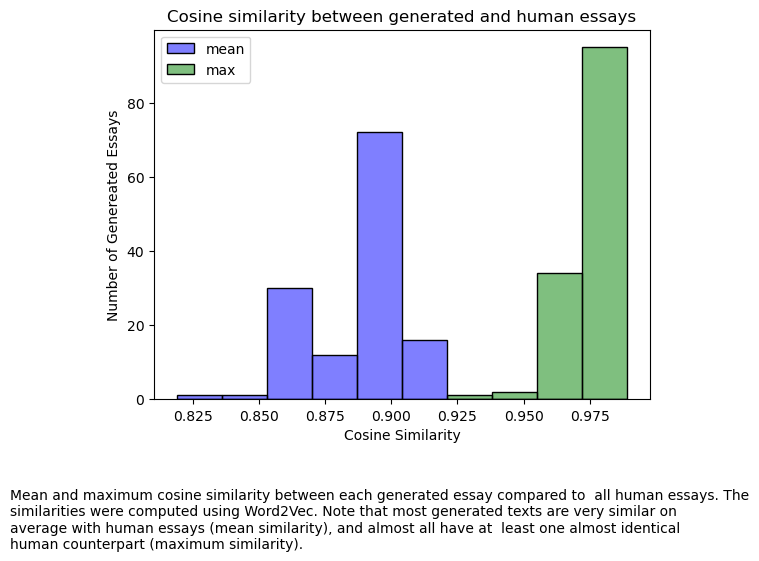

In [36]:
import seaborn as sns
import textwrap


sns.histplot(similarity_df, palette={"mean": "blue", "max": "green"})

caption_text = """Mean and maximum cosine similarity between each generated essay compared to 
all human essays. The similarities were computed using Word2Vec. Note that most generated texts
are very similar on average with human essays (mean similarity), and almost all have at 
least one almost identical human counterpart (maximum similarity).
"""
caption = textwrap.fill(caption_text, width=100)
plt.figtext(-0.1, -0.2, caption)

plt.xlabel("Cosine Similarity")
plt.ylabel("Number of Genereated Essays")
plt.title("Cosine similarity between generated and human essays")
plt.show()

In [37]:
np.unique(similarity_df.id).shape

(132,)

In [38]:
probs = []

# TODO: look into this
print("Starting Leave One Out validation for generated texts...")
for essay_id in tqdm(similarity_df.id):
    essay_train = df[~df.id.eq(essay_id)] 
    essay_test = df[df.id.eq(essay_id)]
    assert essay_test.shape[0] == 1, essay_id
    model = RandomForestClassifier(n_estimators=25)
    model = model.fit(vectorizer.transform(essay_train.text), essay_train.generated)
    probs.append(model.predict_proba(vectorizer.transform(essay_test)))

Starting Leave One Out validation for generated texts...


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [01:42<00:00,  1.28it/s]


In [39]:
similarity_df["probs"] = [x[0][0] for x in probs]
similarity_df

,id,text,mean,max,probs
90,2172896571728,face escalating environmental concerns need su...,0.867101,0.967980,1.00
91,2172895066400,wake growing environmental concerns imperative...,0.865687,0.965399,1.00
92,2172896577904,face pressing environmental concerns need sust...,0.862450,0.965004,1.00
93,2172895069456,"quest sustainable future , limiting car usage ...",0.864773,0.965366,1.00
94,2172897025792,"era marked environmental concerns , health con...",0.859628,0.962974,1.00
...,...,...,...,...,...
154,2172891635040,"dear , hey , hope 're good ! , 've thinking lo...",0.878327,0.956492,0.96
155,2172896017664,"dear , hope letter finds chill . wanted throw ...",0.841934,0.928813,1.00
704,82131f68,"essay analyze , discuss prove one reason favor...",0.869092,0.985460,1.00
740,86fe4f18,strongly believe electoral college remain way ...,0.818765,0.973601,1.00


In [40]:
similarity_df["probs"] = probs
similarity_df

,id,text,mean,max,probs
90,2172896571728,face escalating environmental concerns need su...,0.867101,0.967980,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]"
91,2172895066400,wake growing environmental concerns imperative...,0.865687,0.965399,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]"
92,2172896577904,face pressing environmental concerns need sust...,0.862450,0.965004,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]"
93,2172895069456,"quest sustainable future , limiting car usage ...",0.864773,0.965366,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]"
94,2172897025792,"era marked environmental concerns , health con...",0.859628,0.962974,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]"
...,...,...,...,...,...
154,2172891635040,"dear , hey , hope 're good ! , 've thinking lo...",0.878327,0.956492,"[[0.96, 0.04], [0.96, 0.04], [0.96, 0.04], [0...."
155,2172896017664,"dear , hope letter finds chill . wanted throw ...",0.841934,0.928813,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]"
704,82131f68,"essay analyze , discuss prove one reason favor...",0.869092,0.985460,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]"
740,86fe4f18,strongly believe electoral college remain way ...,0.818765,0.973601,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]"


## Impact of data size

In [41]:
len_splits = np.arange(start=0.1, stop=1.1, step=0.1)
splits = [data_train.sample(int(np.ceil(data_train.shape[0]*i))) for i in len_splits]

sizes = [len(split) for split in splits]
sizes

[106, 211, 317, 422, 527, 633, 738, 844, 949, 1054]

In [42]:
from sklearn.metrics import f1_score


train_scores = []
test_scores = []

for split in splits:
    x_train = vectorizer.transform(split.text)
    y_train = split.generated
    model = RandomForestClassifier(n_estimators=50).fit(x_train, y_train)

    train_preds = model.predict(x_train)
    train_scores.append(f1_score(y_train, train_preds, average="macro"))
    test_preds = model.predict(x_test)
    test_scores.append(f1_score(y_test, test_preds, average="macro"))

train_scores = np.array(train_scores)
test_scores = np.array(test_scores)

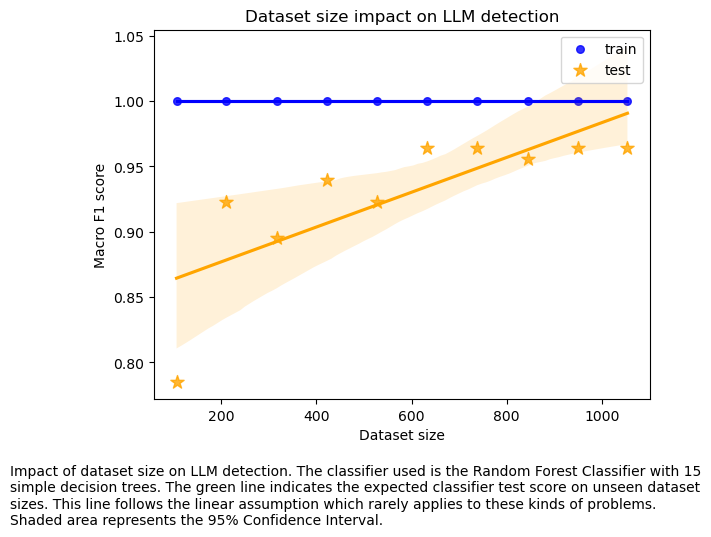

In [43]:
sns.regplot(y=train_scores, 
            x=sizes, 
            label="train", 
            color="blue", 
            scatter_kws={"s": 30})
sns.regplot(y=test_scores,
            x=sizes,
            label="test",
            color="orange",
            marker="*", 
            scatter_kws={"s": 100})

plt.title("Dataset size impact on LLM detection")
plt.ylabel("Macro F1 score")
plt.xlabel("Dataset size")
#plt.ylim(None, 1.1)

# TODO: come back to this once done with data and classifiers
caption_text = "Impact of dataset size on LLM detection. The classifier used is the "\
"Random Forest Classifier with 15 simple decision trees. The green line indicates "\
"the expected classifier test score on unseen dataset sizes. This line follows the "\
"linear assumption which rarely applies to these kinds of problems. Shaded area represents "\
"the 95% Confidence Interval."
caption = textwrap.fill(caption_text, width=100)
plt.figtext(-0.1, -0.15, caption)

plt.legend()
plt.show()

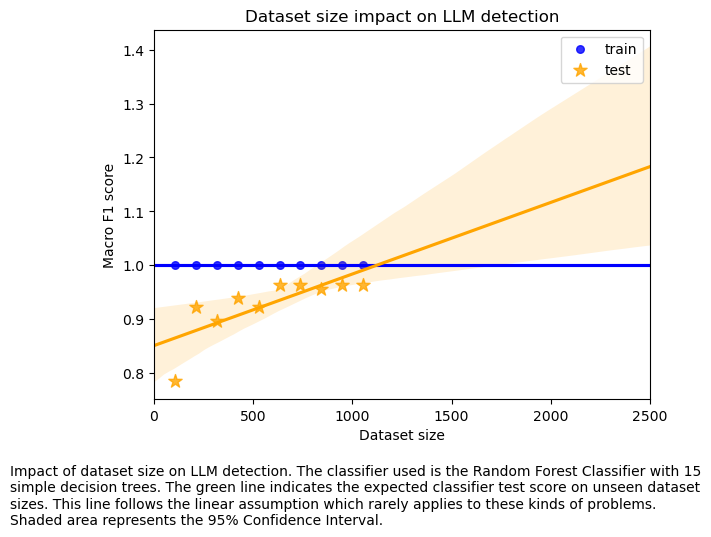

In [44]:
plt.xlim(0, 2500)

sns.regplot(y=train_scores, 
            x=sizes, 
            label="train", 
            color="blue", 
            scatter_kws={"s": 30},
            truncate=False)
sns.regplot(y=test_scores,
            x=sizes,
            label="test",
            color="orange",
            marker="*", 
            scatter_kws={"s": 100},
            truncate=False)

plt.title("Dataset size impact on LLM detection")
plt.ylabel("Macro F1 score")
plt.xlabel("Dataset size")

caption = textwrap.fill(caption_text, width=100)
plt.figtext(-0.1, -0.15, caption)

plt.legend()
plt.show()

## Clustering-based augmentation

https://builtin.com/data-science/elbow-method

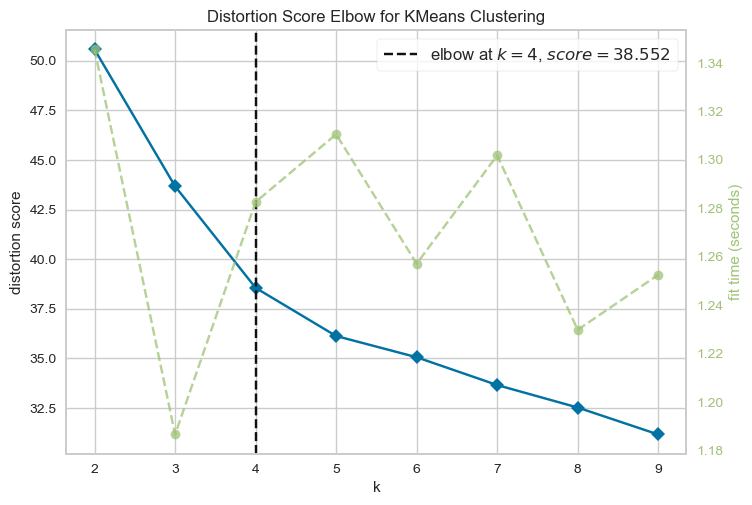

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [45]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

generated_train_df = data_train[data_train.generated == 1].copy()
generated_train = vectorizer.transform(generated_train_df.text).toarray()


# there is an internal memory leak here, don't worry about it
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    km = KMeans(random_state=42, n_init=5)
    visualizer = KElbowVisualizer(km, k=(2,10))
    visualizer.fit(generated_train)        
    
visualizer.show()        

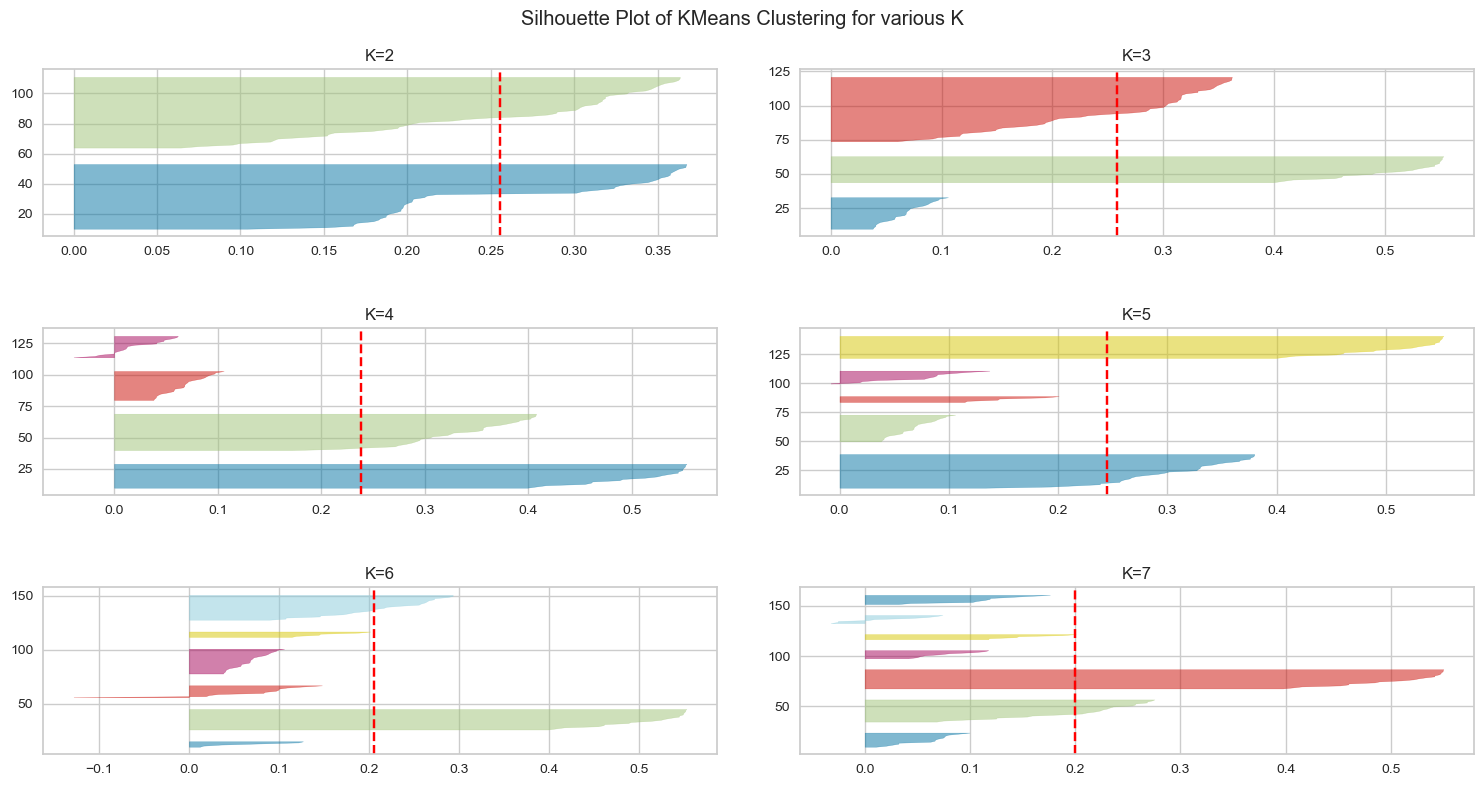

In [46]:
from yellowbrick.cluster import SilhouetteVisualizer


fig, axes = plt.subplots(3, 2, figsize=(15,8))

for i in range(2, 8):
    # there is an internal memory leak here, don't worry about it
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        km = KMeans(n_clusters=i, init='k-means++', n_init=5, random_state=42)
        
        q, mod = divmod(i, 2)
        ax = axes[q-1][mod]
        ax.set_title(f"K={i}")
        
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax)
        visualizer.fit(generated_train) 

fig.suptitle("Silhouette Plot of KMeans Clustering for various K")
fig.tight_layout(h_pad=3, w_pad=3)
#visualizer.show() 

In [47]:
km = KMeans(n_clusters=2, init="k-means++", random_state=42, n_init=10)
preds = km.fit_predict(generated_train)
generated_train_df["cluster"] = preds

C:\Users\user\anaconda3\envs\manis\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


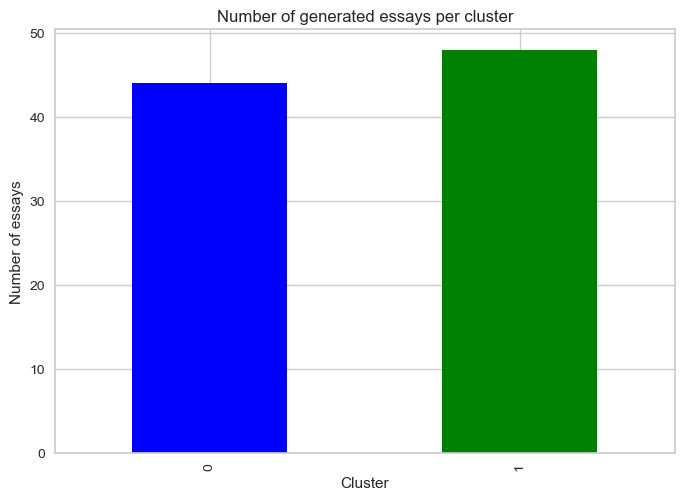

In [48]:
ax = generated_train_df.cluster.value_counts().sort_index().plot(
    kind='bar', 
    color=['blue', 'green', 'red', 'purple'])
ax.set_title("Number of generated essays per cluster")
ax.set_xlabel("Cluster")
ax.set_ylabel("Number of essays")

plt.show()

In [49]:
for cluster in np.unique(generated_train_df.cluster):
    print("=" * 100)
    print(f"Cluster {cluster}")
    for text in generated_train_df[generated_train_df.cluster==1].sample(3).text:
        print("\t\t", text)

Cluster 0
		 dear , hope letter finds chill . wanted throw two cents mix whole electoral college debate . 's like hot topic , right ? say keep , others switching popular vote . 's 'm . , keeping electoral college – 's got quirks , 's bad . get , voting electors instead actual president seems bit weird . , like , 's working , n't ? 's like system folks set ages ago , yeah , maybe 's perfect , 's got rhythm . know electors anyone , big shots ? 's kinda cool . 's like saying , `` hey , regular folks part ! '' imagine neighbor cool aunt elector . 's bit like adding personal touch whole political scene . 's idea electors switch sides mess everything . come , control everything ? people unpredictable . without electoral college , wo n't chaos ? least , 's bit structure , even 's flawless . , without electoral college , candidates focus big states ? little guys might get overlooked . mean , every state matter , right ? electoral college , 's like making sure everyone gets slice political pie 